In [1]:
import requests
import re
import io
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
# from PyPDF2 import PdfFileReader
from pdfminer.high_level import extract_text
import logging
import sys
import pandas as pd


logger = logging.getLogger() 
logger.handlers = [logging.StreamHandler()]
logger.setLevel(logging.INFO)


In [2]:
csv_file = 'data/who-global-cases.csv'
png_file = 'images/who-global-cases.png'

In [3]:
# display the last execute time
datetime.now()

datetime.datetime(2020, 2, 26, 12, 9, 26, 140684)

### Scraping

In [4]:
def analyze_report(url):
    '''
    Analyze a situation report url
    '''
    response = requests.get(url)
    # approach using Py2PDF
    #     f_obj = io.BytesIO(response.content)
    #     pdf = PdfFileReader(f_obj)
    #     page_zero = pdf.getPage(0)  
    #     text  = page_zero.extractText()

    # using pdfminer
    filename=re.sub("[\:\s\.]", "", str(datetime.now()))
    open(filename, "wb").write(response.content)
    text = extract_text(filename)
    
    try:
        # use regular expression to extract date
        p_date = re.compile("Data as reported by .+ (\d+ \w+ 202\d)", re.DOTALL)
        m_date = p_date.search(text)
        report_date_str = m_date.group(1).replace("\n","")
        report_date = datetime.strptime(report_date_str, '%d %B %Y').strftime('%Y-%m-%d')

        # use regular expression to extract global cases
        p_global = re.compile("Globally ([\s\n0-9]+)", re.DOTALL)
        m_global = p_global.search(text)
        global_cases_str = re.sub(r'[\n\s]', '', m_global.group(1))

        global_cases = int(global_cases_str)

        return {"date":report_date, "global_cases": global_cases, "report_url": url}
    except AttributeError as e:
        logger.warning(f'Unable to extract from "{url}" : {e}\n.')
        raise e



In [5]:
def get_reports_urls(home_url):
    '''
    Extract situation reports URL from WHO's page
    '''
    # unable to analyse these reports
    skipped_urls = [
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200126-sitrep-6-2019--ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200125-sitrep-5-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200124-sitrep-4-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200123-sitrep-3-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200122-sitrep-2-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf'
    ]  
    
    urls = []
    response = requests.get(home_url)
    soup = BeautifulSoup(response.content, 'lxml')
    tags = soup.find_all('a')
    for tag in tags:
        if len(tag.contents)>0:
            content = str(tag.contents[0])
            if "Situation report - " in content:
                url = urljoin(home_url ,  tag.get('href')).split('?')[0]
                
                if url not in skipped_urls:
                    urls.append(url)

    return urls


In [6]:
def get_WHO_stats():
    reports_home_url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'
    reports_urls = get_reports_urls(reports_home_url)
    df = pd.read_csv(csv_file)
    for url in reports_urls:
        if df['report_url'].str.contains(url).any():
            print('already processed ', url, ' in previous runs')
            continue
        stats = analyze_report(url)
        df = df.append(stats, ignore_index = True)
    return df

In [7]:
df = get_WHO_stats()

already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200225-sitrep-36-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200224-sitrep-35-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200223-sitrep-34-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200222-sitrep-33-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200221-sitrep-32-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200220-sitrep-31-covid-19.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200219-sitrep-30-covid-19.pdf  in previous runs
already processed  h

In [8]:
df

,date,global_cases,report_url
0,2020-01-27,2798,https://www.who.int/docs/default-source/corona...
1,2020-01-28,4593,https://www.who.int/docs/default-source/corona...
2,2020-01-29,6065,https://www.who.int/docs/default-source/corona...
3,2020-01-30,7818,https://www.who.int/docs/default-source/corona...
4,2020-01-31,9826,https://www.who.int/docs/default-source/corona...
5,2020-02-01,11953,https://www.who.int/docs/default-source/corona...
6,2020-02-02,14557,https://www.who.int/docs/default-source/corona...
7,2020-02-03,17391,https://www.who.int/docs/default-source/corona...
8,2020-02-04,20630,https://www.who.int/docs/default-source/corona...
9,2020-02-05,24554,https://www.who.int/docs/default-source/corona...


### Plot graph and save to files

In [9]:
import seaborn as sns
from pathlib import Path

In [10]:
df.sort_values(by=['date'], inplace=True)

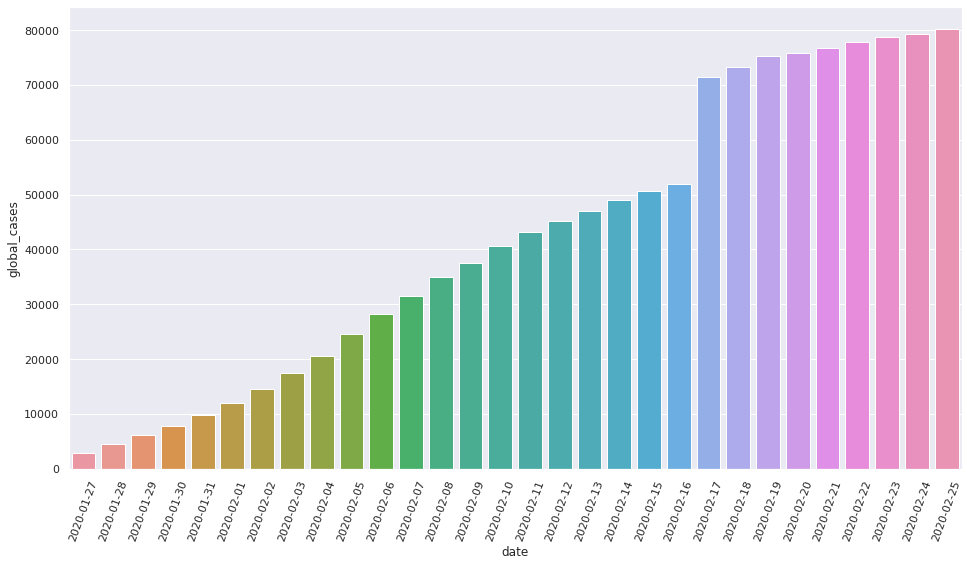

In [11]:
sns.set(rc={'figure.figsize':(16,8.5)})

bar_chart = sns.barplot(x='date', y='global_cases', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [12]:
bar_chart_fig = bar_chart.get_figure()


In [13]:
df.to_csv(csv_file, index=False)
bar_chart_fig.savefig(png_file)
